PyTorch 卷积神经网络 (Convolutional Neural Networks, CNN) 是一类专门用于处理具有网格状拓扑结构数据（如图像）的深度学习模型。

CNN 是计算机视觉任务（如图像分类、目标检测和分割）的核心技术。

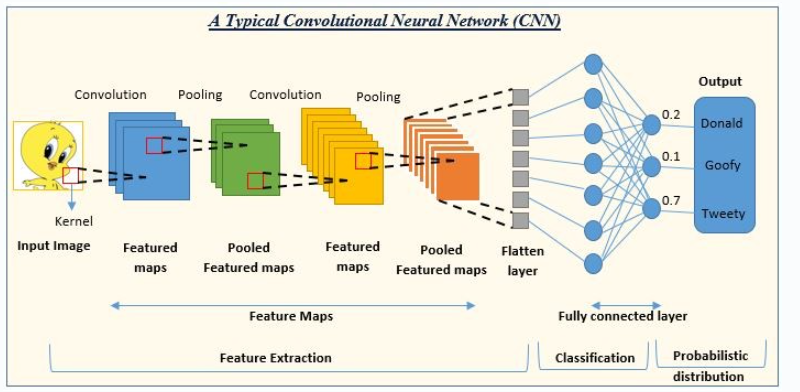


在图中，CNN 的输出层给出了三个类别的概率：Donald（0.2）、Goofy（0.1）和Tweety（0.7），这表明网络认为输入图像最有可能是 Tweety

以下是各个部分的简要说明：

* 输入图像（Input Image）：网络接收的原始图像数据。

* 卷积（Convolution）：使用卷积核（Kernel）在输入图像上滑动，提取特征，生成特征图（Feature Maps）。

* 池化（Pooling）：通常在卷积层之后，通过最大池化或平均池化减少特征图的尺寸，同时保留重要特征，生成池化特征图（Pooled Feature Maps）。

* 特征提取（Feature Extraction）：通过多个卷积和池化层的组合，逐步提取图像的高级特征。

* 展平层（Flatten Layer）：将多维的特征图转换为一维向量，以便输入到全连接层。

* 全连接层（Fully Connected Layer）：类似于传统的神经网络层，用于将提取的特征映射到输出类别。

* 分类（Classification）：网络的输出层，根据全连接层的输出进行分类。

* 概率分布（Probabilistic Distribution）：输出层给出每个类别的概率，表示输入图像属于各个类别的可能性。


以下示例展示如何用 PyTorch 构建一个简单的 CNN 模型，用于 MNIST 数据集的数字分类。

主要步骤：

1. 数据加载与预处理：使用 torchvision 加载和预处理 MNIST 数据。
2. 模型构建：定义卷积层、池化层和全连接层。
3. 训练：通过损失函数和优化器进行模型训练。
4. 评估：测试集上计算模型的准确率。
5. 可视化：展示部分测试样本及其预测结果。

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [5]:
# 1_数据加载
# 使用 torchvision 提供的 MNIST 数据集，加载和预处理数据。

transform = transforms.Compose([
    transforms.ToTensor(), # 转为张量
    transforms.Normalize((0.5,),(0.5,))  #归一化到[-1 ,1]
])

# 加载MNIST数据集
train_dataset = datasets.MNIST(root='./minst_data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./minst_data', train=False, transform=transform, download=True)

train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)



100%|█████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [10:43<00:00, 15.4kB/s]
100%|██████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 124kB/s]
100%|█████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:43<00:00, 38.3kB/s]
100%|█████████████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<?, ?B/s]


In [24]:
# 定义CNN模型
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # 卷积层
        self.cov1 = nn.Conv2d(1, 32, kernel_size = 3, stride=1, padding = 1)
        self.cov2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding = 1)
        # 全连接层
        self.fc1 = nn.Linear(64*7*7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.cov1(x))  # 第一层卷积 + ReLU
        x = F.max_pool2d(x, 2)   # 最大池化
        x = F.relu(self.cov2(x))   # 第二层卷积 + ReLU
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 64*7*7)   #展平
        x = F.relu(self.fc1(x))   # 全连接 + ReLU
        x = self.fc2(x)
        return x

In [26]:
# 创建模型实例
model = SimpleCNN()

# 定义损失函数和优化器
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)


In [33]:
# Model training
num_epochs = 5
model.train()   #设置模式为训练模式

for epoch in range(num_epochs):
    total_loss = 0
    for images, labels in train_dataloader:
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_dataloader):.4f}")

Epoch [1/5], Loss: 0.2145
Epoch [2/5], Loss: 0.1366
Epoch [3/5], Loss: 0.1016
Epoch [4/5], Loss: 0.0838
Epoch [5/5], Loss: 0.0727


In [39]:
# 模型测试
model.eval()
correct = 0
total = 0

with torch.no_grad():  #关闭梯度计算
    for images, labels in test_dataloader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy}%")

Test Accuracy: 98.09%


In [41]:
# 可视化结果

# 本行代码确保matplotlib能在jupyter notebook 中正常运行，notebook有时候会发生kernel崩溃
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

%matplotlib inline

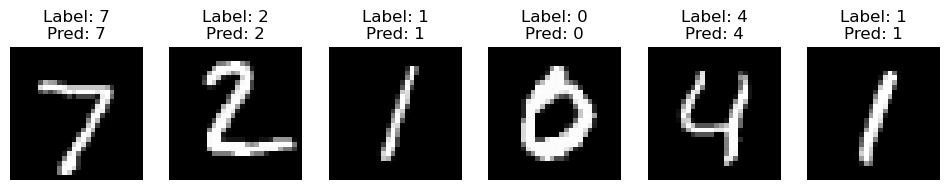

In [45]:
import matplotlib.pyplot as plt

data_iter = iter(test_dataloader)
images, labels = next(data_iter)
outputs = model(images)
_, predictions = torch.max(outputs, 1)

fig, axes = plt.subplots(1, 6, figsize=(12, 4))
for i in range(6):
    axes[i].imshow(images[i][0], cmap='gray')
    axes[i].set_title(f"Label: {labels[i]}\nPred: {predictions[i]}")
    axes[i].axis('off')
plt.show()